In [16]:
from npc.npcor.mcmc import mcmc
from npc.utils import compute_ci as CI
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import warnings
from urllib.parse import urlparse



In [17]:
np.random.seed(498)
warnings.filterwarnings("ignore", category=RuntimeWarning)


def download(url: str, dest_folder: str):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    filename = os.path.basename(urlparse(url).path)  # -> "tdi_1y.h5"
    file_path = os.path.join(dest_folder, filename)
    r = requests.get(url, stream=True)
    if r.ok:
        print("saving to", file_path)
        with open(file_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024*8):
                if chunk:
                    f.write(chunk); f.flush(); os.fsync(f.fileno())
    else:
        print(f"Download failed: status code {r.status_code}\n{r.text}")

def tdi_transfer_functions(freq, armlength=2.5e9):
    """
    TDI transfer functions for test mass and OMS noise.

    Args:
        freq (array): frequencies [Hz]
        armlength (float): LISA arm length [m]

    Returns:
        tuple: (tf_testmass, tf_oms) - transfer function amplitudes
    """
    c = 299792458  # speed of light [m/s]
    L = armlength / c  # arm length in seconds

    # Common TDI factor
    common = (
        16
        * np.sin(2 * np.pi * freq * L) ** 2
        * np.sin(4 * np.pi * freq * L) ** 2
    )

    # Test mass transfer function
    tf_testmass = np.sqrt(common * (3 + np.cos(4 * np.pi * freq * L)))

    # OMS transfer function
    tf_oms = np.sqrt(4 * common)

    return tf_testmass, tf_oms

def oms_noise_asd(
    freq,
    a_OMS=7.9e-12,
    fknee=2e-3,
    central_freq=2.81e14,):
    """
    OMS noise ASD in ISI carrier beatnote fluctuations without filter approximations.

    Args:
        freq (array): frequencies [Hz]
        asd (float): OMS displacement noise parameter[m/s^2]
        fknee (float): knee frequency [Hz]
        central_freq (float): laser central frequency [Hz]
    Returns:
        array: noise PSD [1/Hz]
    """
    c = 299792458
    armlength=2.5e9
    psd_meters = a_OMS**2 * (1 + (fknee / freq) ** 4)
    _, tf_oms = tdi_transfer_functions(freq, armlength)
    asd_hertz = np.sqrt((2 * np.pi * freq * central_freq / c) ** 2 * psd_meters)*tf_oms
    return asd_hertz

def testmass_noise_asd(
    freq,
    a_TM=2.4e-15,
    fknee=4e-4,
    central_freq=2.81e14,
    armlength=2.5e9,
):
    """
    Test mass noise PSD in TMI carrier beatnote fluctuations without filter approximations.

    Args:
        freq (array): frequencies [Hz]
        asd (float): test mass acceleration noise parameter [m/s^2]
        fknee (float): knee frequency [Hz]
        central_freq (float): laser central frequency [Hz]
    Returns:
        array: noise PSD [1/Hz]
    """
    c = 299792458  # speed of light [m/s]
    psd_acc = a_TM**2 * (1 + (fknee / freq) ** 2)
    tf_tm, _ = tdi_transfer_functions(freq, armlength)

    asd_hertz = np.sqrt((2 * central_freq / (2 * np.pi * c * freq)) ** 2 * psd_acc)*tf_tm
    return asd_hertz



In [18]:
# 1 year dataset:
dire = "https://zenodo.org/records/17121928/files"
download(f"{dire}/ddpc_x2_per_1year.txt?download=1", "data")
download(f"{dire}/ddpc_f_1year.txt?download=1", "data")

x2per=np.loadtxt("data/ddpc_x2_per_1year.txt")
freq=np.loadtxt("data/ddpc_f_1year.txt")

saving to data/ddpc_x2_per_1year.txt
saving to data/ddpc_f_1year.txt


In [19]:
# Theoretical noise models
tm=testmass_noise_asd(freq)
oms=oms_noise_asd(freq)
model=np.sqrt(oms**2 + tm**2)

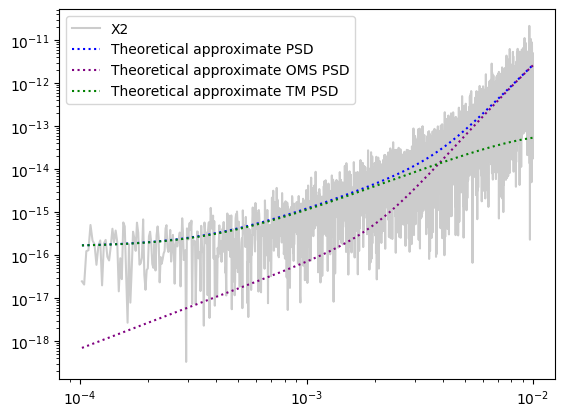

In [20]:
plt.loglog(freq, x2per[0], color="black", alpha=0.2, label="X2")
plt.loglog(freq, model**2, color='blue', linestyle=':', label='Theoretical approximate PSD')
plt.loglog(freq, oms**2, color='purple', linestyle=':', label='Theoretical approximate OMS PSD')
plt.loglog(freq, tm**2, color='green', linestyle=':', label='Theoretical approximate TM PSD')
plt.legend()


In [21]:
result= mcmc(n=1500,
             f=freq,
             per=x2per,
             burnin=1000,
             Spar=oms**2,
             n_knots=10,
             blocked=True,
             thin=10,
             equidistant=True)

ci_spl   = CI(result.splines_psd)
ci_npsd = CI(result.noise_psd)


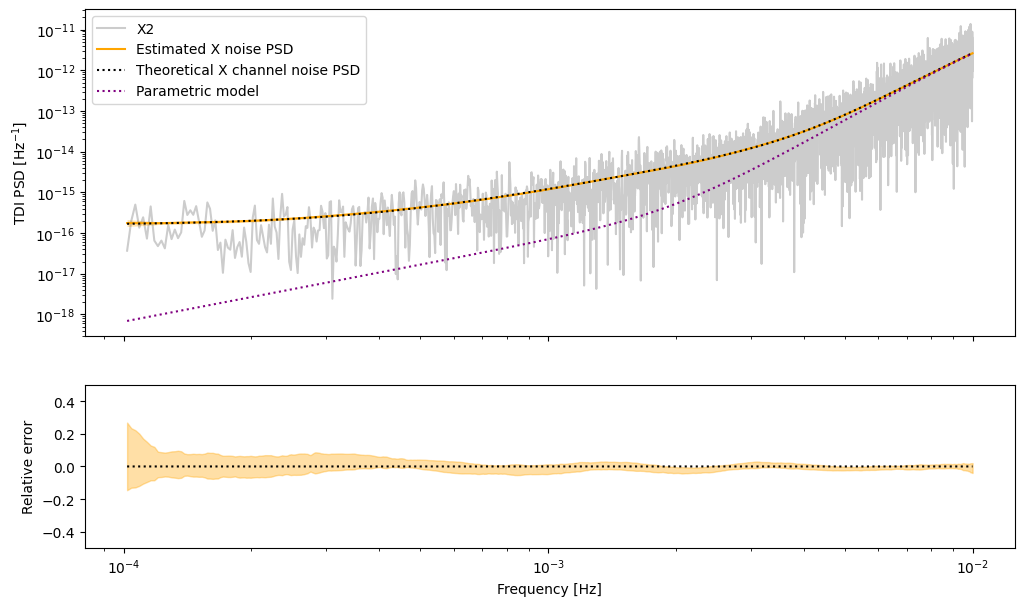

In [22]:
_, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={"height_ratios": [2, 1]})
axes[0].plot(freq,x2per[1],color="black",alpha=0.2,label="X2")
axes[0].plot(freq, np.exp(ci_npsd.med), color='orange', label=f'Estimated X noise PSD')
axes[0].fill_between(freq, np.exp(ci_npsd.u05), np.exp(ci_npsd.u95),
                     color='orange', alpha=0.3, linewidth=0)
axes[0].plot(freq, model**2 , color='black', linestyle=':',
             label=f'Theoretical X channel noise PSD')
axes[0].plot(freq, oms**2, color='purple', label='Parametric model', linestyle=':')
axes[0].set_ylabel(r"TDI PSD [$\mathrm{Hz}^{-1}$]")
axes[0].legend()
axes[0].set_yscale("log")
axes[0].set_xscale("log")

err_low  = (np.exp(ci_npsd.u05) - model**2) / model**2
err_high = (np.exp(ci_npsd.u95) - model**2) / model**2
axes[1].fill_between(freq, err_low, err_high,
                        color="orange", alpha=0.35)
axes[1].semilogx(freq, np.zeros_like(freq), color="black", linestyle=":")
axes[1].set_ylim(-0.5, 0.5)
axes[1].set_xlabel("Frequency [Hz]")
axes[1].set_ylabel("Relative error")
plt.savefig("/home/naim769/lisa_demo.png", dpi=300)